In [1]:
import subprocess
import pandas as pd
import os

In [2]:
from sklearn.model_selection import ParameterSampler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import itertools
import time

## make mcmc grisearch

In [3]:
stds = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
sigma_classs = [0.2, 0.5, 0.75, 1.0, 1.25, 1.5]
#beam_sizes = [1, 30, 100]
#num_stepss = [5, 30, 100]
sigma_wers = [0.2, 0.5, 0.75, 1.0, 1.25, 1.5]

In [4]:
sampler = ParameterSampler(
{'std':stds, 'sigma_class':sigma_classs, 'sigma_wer':sigma_wers}, 30)

In [6]:
#params = list(itertools.product(beam_sizes, num_stepss))

In [18]:
dataset = 'ai_academy_data'
#dataset = 'ag_news'

In [8]:
beam_size, num_steps = 30, 30

In [9]:
pbar = tqdm(total=sampler.n_iter)
#for beam_size, num_steps in params:
for s in sampler:
    std = s['std']
    sigma_wer = s['sigma_wer']
    sigma_class = s['sigma_class']
    print(beam_size, num_steps, std, sigma_wer, sigma_class)
    cmd = \
    f'''
    python run_mcmc.py 
    --csv_path data/{dataset}/test.csv 
    --results_path results/{dataset}/mcmc 
    --classifier_path experiments/{dataset}/classifier_basic 
    --copynet_path experiments/{dataset}/nonmasked_copynet 
    --beam_size {beam_size}  
    --cuda 0 
    --sample 100 
    --std {std}
    --sigma_class {sigma_class}
    --sigma_wer {sigma_wer}
    --num_steps {num_steps}
    '''.replace('\n','')
    print(cmd)
    result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
    pbar.update(1)
pbar.close()

  0%|          | 0/30 [00:00<?, ?it/s]

30 30 0.05 1.25 0.2
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.05    --sigma_class 0.2    --sigma_wer 1.25    --num_steps 30    


  3%|▎         | 1/30 [00:01<00:48,  1.66s/it]

30 30 0.5 1.0 1.0
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.5    --sigma_class 1.0    --sigma_wer 1.0    --num_steps 30    


  7%|▋         | 2/30 [00:03<00:46,  1.67s/it]

30 30 0.05 1.5 0.5
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.05    --sigma_class 0.5    --sigma_wer 1.5    --num_steps 30    


 10%|█         | 3/30 [00:05<00:45,  1.67s/it]

30 30 0.05 1.5 1.5
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.05    --sigma_class 1.5    --sigma_wer 1.5    --num_steps 30    


 13%|█▎        | 4/30 [00:06<00:43,  1.67s/it]

30 30 1.0 1.0 1.0
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 1.0    --sigma_class 1.0    --sigma_wer 1.0    --num_steps 30    


 17%|█▋        | 5/30 [00:08<00:41,  1.66s/it]

30 30 0.01 1.25 1.0
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.01    --sigma_class 1.0    --sigma_wer 1.25    --num_steps 30    


 20%|██        | 6/30 [00:09<00:39,  1.66s/it]

30 30 0.1 0.5 1.25
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.1    --sigma_class 1.25    --sigma_wer 0.5    --num_steps 30    


 23%|██▎       | 7/30 [00:11<00:38,  1.66s/it]

30 30 1.0 0.5 1.25
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 1.0    --sigma_class 1.25    --sigma_wer 0.5    --num_steps 30    


 27%|██▋       | 8/30 [00:13<00:36,  1.66s/it]

30 30 1.0 1.0 1.25
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 1.0    --sigma_class 1.25    --sigma_wer 1.0    --num_steps 30    


 30%|███       | 9/30 [00:14<00:34,  1.66s/it]

30 30 0.01 0.2 0.5
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.01    --sigma_class 0.5    --sigma_wer 0.2    --num_steps 30    


 33%|███▎      | 10/30 [00:16<00:32,  1.65s/it]

30 30 1.0 0.5 0.2
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 1.0    --sigma_class 0.2    --sigma_wer 0.5    --num_steps 30    


 37%|███▋      | 11/30 [00:18<00:31,  1.65s/it]

30 30 0.05 0.2 0.2
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.05    --sigma_class 0.2    --sigma_wer 0.2    --num_steps 30    


 40%|████      | 12/30 [00:21<00:37,  2.06s/it]

30 30 0.1 0.5 0.2
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.1    --sigma_class 0.2    --sigma_wer 0.5    --num_steps 30    


 43%|████▎     | 13/30 [00:22<00:32,  1.94s/it]

30 30 1.0 1.5 0.5
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 1.0    --sigma_class 0.5    --sigma_wer 1.5    --num_steps 30    


 47%|████▋     | 14/30 [00:24<00:29,  1.86s/it]

30 30 1.0 0.5 1.0
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 1.0    --sigma_class 1.0    --sigma_wer 0.5    --num_steps 30    


 50%|█████     | 15/30 [00:26<00:26,  1.80s/it]

30 30 0.5 1.5 0.5
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.5    --sigma_class 0.5    --sigma_wer 1.5    --num_steps 30    


 53%|█████▎    | 16/30 [00:27<00:24,  1.75s/it]

30 30 0.2 1.0 1.0
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.2    --sigma_class 1.0    --sigma_wer 1.0    --num_steps 30    


 57%|█████▋    | 17/30 [00:29<00:22,  1.72s/it]

30 30 0.5 0.75 0.5
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.5    --sigma_class 0.5    --sigma_wer 0.75    --num_steps 30    


 60%|██████    | 18/30 [00:31<00:20,  1.71s/it]

30 30 0.2 0.5 0.2
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.2    --sigma_class 0.2    --sigma_wer 0.5    --num_steps 30    


 63%|██████▎   | 19/30 [00:32<00:18,  1.70s/it]

30 30 0.2 1.5 0.75
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.2    --sigma_class 0.75    --sigma_wer 1.5    --num_steps 30    


 67%|██████▋   | 20/30 [00:34<00:16,  1.69s/it]

30 30 0.01 1.25 0.2
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.01    --sigma_class 0.2    --sigma_wer 1.25    --num_steps 30    


 70%|███████   | 21/30 [00:36<00:15,  1.69s/it]

30 30 0.2 1.0 0.5
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.2    --sigma_class 0.5    --sigma_wer 1.0    --num_steps 30    


 73%|███████▎  | 22/30 [00:37<00:13,  1.70s/it]

30 30 0.1 1.25 0.5
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.1    --sigma_class 0.5    --sigma_wer 1.25    --num_steps 30    


 77%|███████▋  | 23/30 [00:39<00:11,  1.70s/it]

30 30 0.2 0.75 1.5
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.2    --sigma_class 1.5    --sigma_wer 0.75    --num_steps 30    


 80%|████████  | 24/30 [00:41<00:10,  1.69s/it]

30 30 1.0 0.2 0.2
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 1.0    --sigma_class 0.2    --sigma_wer 0.2    --num_steps 30    


 83%|████████▎ | 25/30 [00:42<00:08,  1.68s/it]

30 30 0.1 1.0 0.2
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.1    --sigma_class 0.2    --sigma_wer 1.0    --num_steps 30    


 87%|████████▋ | 26/30 [00:44<00:06,  1.68s/it]

30 30 0.5 0.2 0.2
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.5    --sigma_class 0.2    --sigma_wer 0.2    --num_steps 30    


 90%|█████████ | 27/30 [00:46<00:05,  1.67s/it]

30 30 1.0 0.75 0.2
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 1.0    --sigma_class 0.2    --sigma_wer 0.75    --num_steps 30    


 93%|█████████▎| 28/30 [00:47<00:03,  1.67s/it]

30 30 0.2 1.25 1.5
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 0.2    --sigma_class 1.5    --sigma_wer 1.25    --num_steps 30    


 97%|█████████▋| 29/30 [00:49<00:01,  1.66s/it]

30 30 1.0 0.75 0.5
    python run_mcmc.py     --csv_path data/ag_news/test.csv     --results_path results/ag_news/mcmc     --classifier_path experiments/ag_news/classifier_basic     --copynet_path experiments/ag_news/nonmasked_copynet     --beam_size 30      --cuda 0     --sample 100     --std 1.0    --sigma_class 0.5    --sigma_wer 0.75    --num_steps 30    


100%|██████████| 30/30 [00:51<00:00,  1.71s/it]


## make random grisearch

In [19]:
beam_size = 1

In [20]:
dataset

'ai_academy_data'

In [33]:
#for beam_size, num_steps in params:
for std in tqdm(std):
    print(beam_size, num_steps, std)
    cmd = \
    f'''
    python run_mcmc.py 
    --csv_path data/{dataset}/test.csv 
    --results_path results/{dataset}/random 
    --classifier_path experiments/{dataset}/classifier_basic 
    --copynet_path experiments/{dataset}/nonmasked_copynet 
    --beam_size {beam_size}  
    --cuda 0 
    --sample 100 
    --std {std}
    --num_steps {num_steps}
    --random
    '''.replace('\n','')
    print(cmd)
    result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)

  0%|          | 0/3 [00:00<?, ?it/s]

1 30 2
    python run_mcmc.py     --csv_path data/ai_academy_data/test.csv     --results_path results/ai_academy_data/random     --classifier_path experiments/ai_academy_data/classifier_basic     --copynet_path experiments/ai_academy_data/nonmasked_copynet     --beam_size 1      --cuda 0     --sample 100     --std 2    --num_steps 30    --random    


 33%|███▎      | 1/3 [00:19<00:38, 19.30s/it]

1 30 5
    python run_mcmc.py     --csv_path data/ai_academy_data/test.csv     --results_path results/ai_academy_data/random     --classifier_path experiments/ai_academy_data/classifier_basic     --copynet_path experiments/ai_academy_data/nonmasked_copynet     --beam_size 1      --cuda 0     --sample 100     --std 5    --num_steps 30    --random    


 67%|██████▋   | 2/3 [00:37<00:18, 18.83s/it]

1 30 10
    python run_mcmc.py     --csv_path data/ai_academy_data/test.csv     --results_path results/ai_academy_data/random     --classifier_path experiments/ai_academy_data/classifier_basic     --copynet_path experiments/ai_academy_data/nonmasked_copynet     --beam_size 1      --cuda 0     --sample 100     --std 10    --num_steps 30    --random    


100%|██████████| 3/3 [00:56<00:00, 18.75s/it]


In [3]:
from eval import calculate_nad, calculate_metrics
import joblib
import json
from adat.models.classification_model import LogisticRegressionOnTfIdf

In [4]:
base_dir = f'results/{dataset}'

NameError: name 'dataset' is not defined

In [36]:
base_dir

'results/ai_academy_data'

In [37]:
model = joblib.load(f'results/{dataset}/logit_tfidf.model')

for method in ['mcmc', 'random']:
    base = os.path.join(base_dir, method)
    for folder in os.listdir(base):
        if folder != 'backup':
            attack_results_path = f'{base}/{folder}/results.csv'
            eval_results_path = f'{base}/{folder}/eval_metric.json'
            df = pd.read_csv(attack_results_path)
            df.rename(columns={'generated_sequence':'adversarial_sequence'}, inplace=True)
            metrics = calculate_metrics(model, 
                                    df['label'].values, 
                                    df['sequence'].values,
                                    df['adversarial_sequence'].values)
            json.dump(metrics, open(eval_results_path, 'w'))

In [26]:
result = []
for method in ['mcmc']:
    base = os.path.join(base_dir, method)
    for folder in os.listdir(base):
        if folder != 'backup':
            args = json.load(open(os.path.join(base, folder, 'args.json')))
            metrics = json.load(open(os.path.join(base, folder, 'eval_metric.json')))
            args.update(metrics)
            result.append({k:args[k] for k in ['accuracy_drop', 'probability_drop', 'WER', 'NAD',
                                                'beam_size', 'num_steps', 'std', 'sigma_wer', 'sigma_class']})
result = pd.DataFrame(result)

In [27]:
result

,accuracy_drop,probability_drop,WER,NAD,beam_size,num_steps,std,sigma_wer,sigma_class
0,0.27,0.100129,4.99,0.139459,30,30,0.20,0.75,1.25
1,0.03,0.022052,0.92,0.010078,30,30,0.01,1.50,0.20
2,0.27,0.097047,4.83,0.139459,30,30,0.01,0.50,1.00
3,0.27,0.100129,4.99,0.139459,30,30,0.50,1.25,0.75
4,0.23,0.095047,4.41,0.109574,30,30,0.05,0.75,0.50
5,0.26,0.097518,4.71,0.136483,30,30,0.10,1.00,0.50
6,0.25,0.092292,4.67,0.135482,30,30,0.10,0.50,1.50
7,0.27,0.100129,4.99,0.139459,30,30,0.01,1.25,1.25
8,0.04,0.020932,0.85,0.013005,30,30,0.20,0.75,0.20
9,0.06,0.018695,0.59,0.035250,30,30,0.01,0.50,0.20


In [28]:
sns.set()

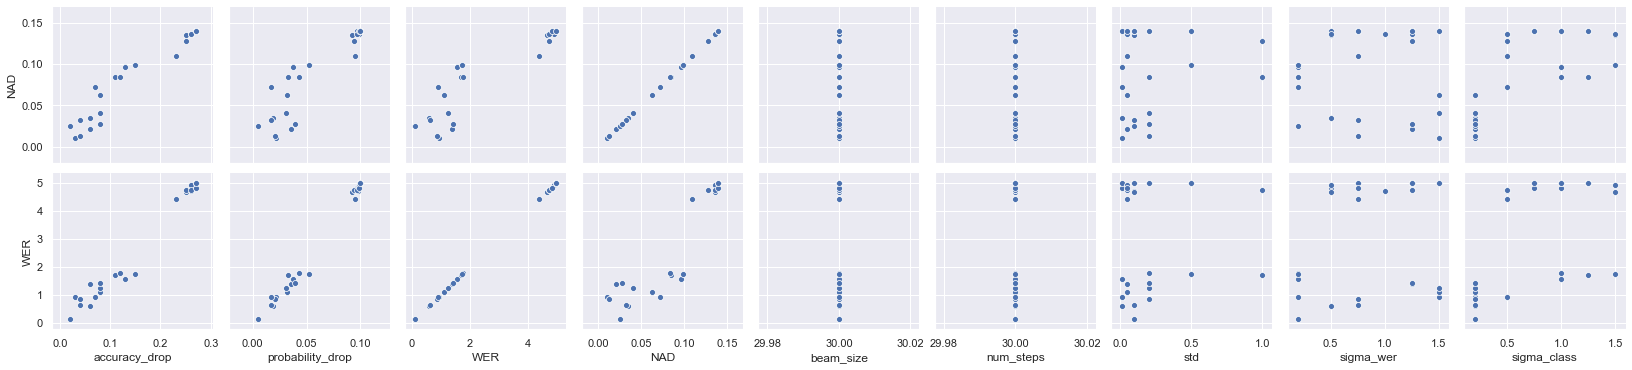

In [29]:
g = sns.pairplot(result, x_vars=result.columns.values, y_vars=['NAD', 'WER'])
plt.savefig(os.path.join(base_dir, f'stats_{method}.png'), dpi=150, bbox_inches='tight')

In [30]:
result.sort_values(by='NAD', ascending=False)

,accuracy_drop,probability_drop,WER,NAD,beam_size,num_steps,std,sigma_wer,sigma_class
0,0.27,0.100129,4.99,0.139459,30,30,0.20,0.75,1.25
7,0.27,0.100129,4.99,0.139459,30,30,0.01,1.25,1.25
21,0.27,0.098991,4.83,0.139459,30,30,0.05,0.75,0.75
13,0.27,0.100129,4.99,0.139459,30,30,0.20,1.25,1.00
12,0.27,0.100129,4.99,0.139459,30,30,0.10,1.25,1.00
11,0.27,0.100129,4.99,0.139459,30,30,0.50,0.75,1.25
25,0.27,0.100129,4.99,0.139459,30,30,0.10,1.25,0.75
17,0.27,0.100129,4.99,0.139459,30,30,0.10,1.50,1.25
3,0.27,0.100129,4.99,0.139459,30,30,0.50,1.25,0.75
2,0.27,0.097047,4.83,0.139459,30,30,0.01,0.50,1.00


In [38]:
result = []
for method in ['random']:
    base = os.path.join(base_dir, method)
    for folder in os.listdir(base):
        if folder != 'backup':
            args = json.load(open(os.path.join(base, folder, 'args.json')))
            metrics = json.load(open(os.path.join(base, folder, 'eval_metric.json')))
            args.update(metrics)
            result.append({k:args[k] for k in ['accuracy_drop', 'probability_drop', 'WER', 'NAD',
                                                'beam_size', 'num_steps', 'std']})
result = pd.DataFrame(result)

In [39]:
result.sort_values(by='NAD', ascending=False)

,accuracy_drop,probability_drop,WER,NAD,beam_size,num_steps,std
0,0.26,0.086715,5.94,0.148140,30,30,1.00
5,0.26,0.086715,5.94,0.148140,30,30,0.10
6,0.26,0.086715,5.94,0.148140,30,30,0.50
7,0.26,0.086715,5.94,0.148140,30,30,0.20
11,0.26,0.086715,5.94,0.148140,30,30,0.05
12,0.26,0.086715,5.94,0.148140,30,30,0.01
1,0.16,0.034560,6.94,0.086443,1,30,0.01
2,0.16,0.034560,6.94,0.086443,1,30,1.00
3,0.16,0.034560,6.94,0.086443,1,30,5.00
4,0.16,0.034560,6.94,0.086443,1,30,0.10


## make cascada grisearch

In [5]:
levenshtein_weights = [0.1, 1, 10]
beam_sizes = [1, 30, 100]
max_stepss = [5, 30, 100]
learning_rates = [1, 2, 4]

In [6]:
import itertools

In [7]:
params = list(itertools.product(levenshtein_weights, beam_sizes, max_stepss, learning_rates))

In [8]:
dataset = 'insurance'

In [10]:
for p in tqdm(params):
    print(p)
    levenshtein_weight, beam_size, max_steps, learning_rate = p
    cmd = \
    f'''
    python run_cascada.py 
    --csv_path data/{dataset}/test.csv 
    --results_path results/{dataset}/cascada
    --classifier_path experiments/{dataset}/classification_copynet 
    --levenshtein_path experiments/{dataset}/deep_levenshtein_copynet 
    --copynet_path experiments/{dataset}/nonmasked_copynet_with_attention 
    --levenshtein_weight {levenshtein_weight}
    --beam_size {beam_size} 
    --max_steps {max_steps}
    --cuda 0 
    --num_updates 5 
    --learning_rate {learning_rate} 
    --sample 100
    '''.replace('\n','')
    #break
    result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)

  0%|          | 0/81 [00:00<?, ?it/s]

(0.1, 1, 5, 1)


  1%|          | 1/81 [00:08<11:41,  8.77s/it]

(0.1, 1, 5, 2)


  2%|▏         | 2/81 [00:18<12:06,  9.19s/it]

(0.1, 1, 5, 4)


  4%|▎         | 3/81 [00:28<12:06,  9.31s/it]

(0.1, 1, 30, 1)


  5%|▍         | 4/81 [01:05<22:32, 17.56s/it]

(0.1, 1, 30, 2)


  6%|▌         | 5/81 [01:48<31:49, 25.13s/it]

(0.1, 1, 30, 4)


  7%|▋         | 6/81 [02:36<40:05, 32.07s/it]

(0.1, 1, 100, 1)


  9%|▊         | 7/81 [04:53<1:18:26, 63.60s/it]

(0.1, 1, 100, 2)


 10%|▉         | 8/81 [07:17<1:46:50, 87.82s/it]

(0.1, 1, 100, 4)


 11%|█         | 9/81 [10:01<2:12:50, 110.70s/it]

(0.1, 30, 5, 1)


 12%|█▏        | 10/81 [10:12<1:35:17, 80.53s/it]

(0.1, 30, 5, 2)


 14%|█▎        | 11/81 [10:24<1:09:57, 59.96s/it]

(0.1, 30, 5, 4)


 15%|█▍        | 12/81 [10:35<52:19, 45.50s/it]  

(0.1, 30, 30, 1)


 16%|█▌        | 13/81 [11:25<52:48, 46.60s/it]

(0.1, 30, 30, 2)


 17%|█▋        | 14/81 [12:22<55:32, 49.74s/it]

(0.1, 30, 30, 4)


 19%|█▊        | 15/81 [13:28<1:00:12, 54.74s/it]

(0.1, 30, 100, 1)


 20%|█▉        | 16/81 [16:23<1:38:27, 90.88s/it]

(0.1, 30, 100, 2)


 21%|██        | 17/81 [19:46<2:12:47, 124.50s/it]

(0.1, 30, 100, 4)


 22%|██▏       | 18/81 [23:32<2:42:30, 154.78s/it]

(0.1, 100, 5, 1)


 23%|██▎       | 19/81 [23:47<1:56:43, 112.96s/it]

(0.1, 100, 5, 2)


 25%|██▍       | 20/81 [24:01<1:24:47, 83.40s/it] 

(0.1, 100, 5, 4)


 26%|██▌       | 21/81 [24:18<1:03:24, 63.41s/it]

(0.1, 100, 30, 1)


 27%|██▋       | 22/81 [25:29<1:04:33, 65.64s/it]

(0.1, 100, 30, 2)


 28%|██▊       | 23/81 [26:51<1:08:11, 70.55s/it]

(0.1, 100, 30, 4)


 30%|██▉       | 24/81 [28:22<1:12:42, 76.54s/it]

(0.1, 100, 100, 1)


 31%|███       | 25/81 [32:47<2:04:21, 133.24s/it]

(0.1, 100, 100, 2)


 32%|███▏      | 26/81 [37:23<2:41:22, 176.04s/it]

(0.1, 100, 100, 4)


 33%|███▎      | 27/81 [42:26<3:12:39, 214.07s/it]

(1, 1, 5, 1)


 35%|███▍      | 28/81 [42:35<2:14:42, 152.50s/it]

(1, 1, 5, 2)


 36%|███▌      | 29/81 [42:46<1:35:25, 110.10s/it]

(1, 1, 5, 4)


 37%|███▋      | 30/81 [42:57<1:08:18, 80.37s/it] 

(1, 1, 30, 1)


 38%|███▊      | 31/81 [43:39<57:32, 69.06s/it]  

(1, 1, 30, 2)


 40%|███▉      | 32/81 [44:31<52:03, 63.74s/it]

(1, 1, 30, 4)


 41%|████      | 33/81 [45:26<48:57, 61.19s/it]

(1, 1, 100, 1)


 42%|████▏     | 34/81 [47:47<1:06:37, 85.06s/it]

(1, 1, 100, 2)


 43%|████▎     | 35/81 [50:23<1:21:41, 106.56s/it]

(1, 1, 100, 4)


 44%|████▍     | 36/81 [53:17<1:35:00, 126.68s/it]

(1, 30, 5, 1)


 46%|████▌     | 37/81 [53:29<1:07:41, 92.32s/it] 

(1, 30, 5, 2)


 47%|████▋     | 38/81 [53:41<48:47, 68.07s/it]  

(1, 30, 5, 4)


 48%|████▊     | 39/81 [53:53<35:59, 51.43s/it]

(1, 30, 30, 1)


 49%|████▉     | 40/81 [54:50<36:10, 52.95s/it]

(1, 30, 30, 2)


 51%|█████     | 41/81 [55:53<37:17, 55.93s/it]

(1, 30, 30, 4)


 52%|█████▏    | 42/81 [57:01<38:41, 59.53s/it]

(1, 30, 100, 1)


 53%|█████▎    | 43/81 [1:00:20<1:04:16, 101.50s/it]

(1, 30, 100, 2)


 54%|█████▍    | 44/81 [1:03:55<1:23:28, 135.37s/it]

(1, 30, 100, 4)


 56%|█████▌    | 45/81 [1:07:40<1:37:27, 162.44s/it]

(1, 100, 5, 1)


 57%|█████▋    | 46/81 [1:07:55<1:08:51, 118.04s/it]

(1, 100, 5, 2)


 58%|█████▊    | 47/81 [1:08:10<49:25, 87.21s/it]   

(1, 100, 5, 4)


 59%|█████▉    | 48/81 [1:08:26<36:16, 65.97s/it]

(1, 100, 30, 1)


 60%|██████    | 49/81 [1:09:48<37:46, 70.84s/it]

(1, 100, 30, 2)


 62%|██████▏   | 50/81 [1:11:16<39:09, 75.78s/it]

(1, 100, 30, 4)


 63%|██████▎   | 51/81 [1:12:46<40:00, 80.02s/it]

(1, 100, 100, 1)


 64%|██████▍   | 52/81 [1:17:26<1:07:46, 140.23s/it]

(1, 100, 100, 2)


 65%|██████▌   | 53/81 [1:22:21<1:27:01, 186.48s/it]

(1, 100, 100, 4)


 67%|██████▋   | 54/81 [1:27:33<1:40:55, 224.29s/it]

(10, 1, 5, 1)


 68%|██████▊   | 55/81 [1:27:44<1:09:24, 160.19s/it]

(10, 1, 5, 2)


 69%|██████▉   | 56/81 [1:27:55<48:09, 115.59s/it]  

(10, 1, 5, 4)


 70%|███████   | 57/81 [1:28:10<34:06, 85.27s/it] 

(10, 1, 30, 1)


 72%|███████▏  | 58/81 [1:29:05<29:10, 76.09s/it]

(10, 1, 30, 2)


 73%|███████▎  | 59/81 [1:30:06<26:13, 71.53s/it]

(10, 1, 30, 4)


 74%|███████▍  | 60/81 [1:31:08<24:03, 68.75s/it]

(10, 1, 100, 1)


 75%|███████▌  | 61/81 [1:34:11<34:24, 103.21s/it]

(10, 1, 100, 2)


 77%|███████▋  | 62/81 [1:37:20<40:48, 128.86s/it]

(10, 1, 100, 4)


 78%|███████▊  | 63/81 [1:40:33<44:26, 148.12s/it]

(10, 30, 5, 1)


 79%|███████▉  | 64/81 [1:40:46<30:25, 107.41s/it]

(10, 30, 5, 2)


 80%|████████  | 65/81 [1:41:00<21:12, 79.52s/it] 

(10, 30, 5, 4)


 81%|████████▏ | 66/81 [1:41:13<14:55, 59.67s/it]

(10, 30, 30, 1)


 83%|████████▎ | 67/81 [1:42:20<14:22, 61.62s/it]

(10, 30, 30, 2)


 84%|████████▍ | 68/81 [1:43:30<13:53, 64.14s/it]

(10, 30, 30, 4)


 85%|████████▌ | 69/81 [1:44:39<13:09, 65.83s/it]

(10, 30, 100, 1)


 86%|████████▋ | 70/81 [1:48:22<20:42, 112.93s/it]

(10, 30, 100, 2)


 88%|████████▊ | 71/81 [1:52:04<24:15, 145.51s/it]

(10, 30, 100, 4)


 89%|████████▉ | 72/81 [1:55:59<25:51, 172.40s/it]

(10, 100, 5, 1)


 90%|█████████ | 73/81 [1:56:17<16:48, 126.01s/it]

(10, 100, 5, 2)


 91%|█████████▏| 74/81 [1:56:33<10:52, 93.19s/it] 

(10, 100, 5, 4)


 93%|█████████▎| 75/81 [1:56:52<07:04, 70.83s/it]

(10, 100, 30, 1)


 94%|█████████▍| 76/81 [1:58:25<06:27, 77.44s/it]

(10, 100, 30, 2)


 95%|█████████▌| 77/81 [1:59:58<05:29, 82.33s/it]

(10, 100, 30, 4)


 96%|█████████▋| 78/81 [2:01:36<04:20, 86.94s/it]

(10, 100, 100, 1)


 98%|█████████▊| 79/81 [2:06:41<05:04, 152.25s/it]

(10, 100, 100, 2)


 99%|█████████▉| 80/81 [2:11:58<03:21, 201.76s/it]

(10, 100, 100, 4)


100%|██████████| 81/81 [2:17:13<00:00, 101.65s/it]


In [9]:
cmd

'    python run_cascada.py     --csv_path data/insurance/test.csv     --results_path results/insurance/cascada    --classifier_path experiments/insurance/classification_copynet     --levenshtein_path experiments/insurance/deep_levenshtein_copynet     --copynet_path experiments/insurance/nonmasked_copynet_with_attention     --levenshtein_weight 0.1    --beam_size 1     --max_steps 5    --cuda 0     --num_updates 5     --learning_rate 1     --sample 100    '

In [9]:
base_dir = f'results/{dataset}'

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
model_with_weights = joblib.load(f'results/{dataset}/logit_tfidf.model')
model = model_with_weights['model']
w = model_with_weights['weights']
for method in ['cascada']:
    base = os.path.join(base_dir, method)
    for folder in os.listdir(base):
        if folder != 'backup':
            attack_results_path = f'{base}/{folder}/results.csv'
            eval_results_path = f'{base}/{folder}/eval_metric.json'
            df = pd.read_csv(attack_results_path)
            metrics = calculate_metrics(model, w, 
                                    df['label'].values, 
                                    df['sequence'].values,
                                    df['adversarial_sequence'].values)
            json.dump(metrics, open(eval_results_path, 'w'))

In [30]:
w

array([0.03540153, 0.41077302])

In [25]:
result = []
for method in ['cascada']:
    base = os.path.join(base_dir, method)
    for folder in os.listdir(base):
        if folder != 'backup':
            args = json.load(open(os.path.join(base, folder, 'args.json')))
            metrics = json.load(open(os.path.join(base, folder, 'eval_metric.json')))
            args.update(metrics)
            result.append({k:args[k] for k in ['roc_auc_drop', 'accuracy_drop', 'probability_drop', 'WER', 'NAD',
                                               'levenshtein_weight', 'beam_size', 'max_steps', 'learning_rate']})
result = pd.DataFrame(result)

In [26]:
base_dir

'results/insurance'

In [27]:
sns.set()

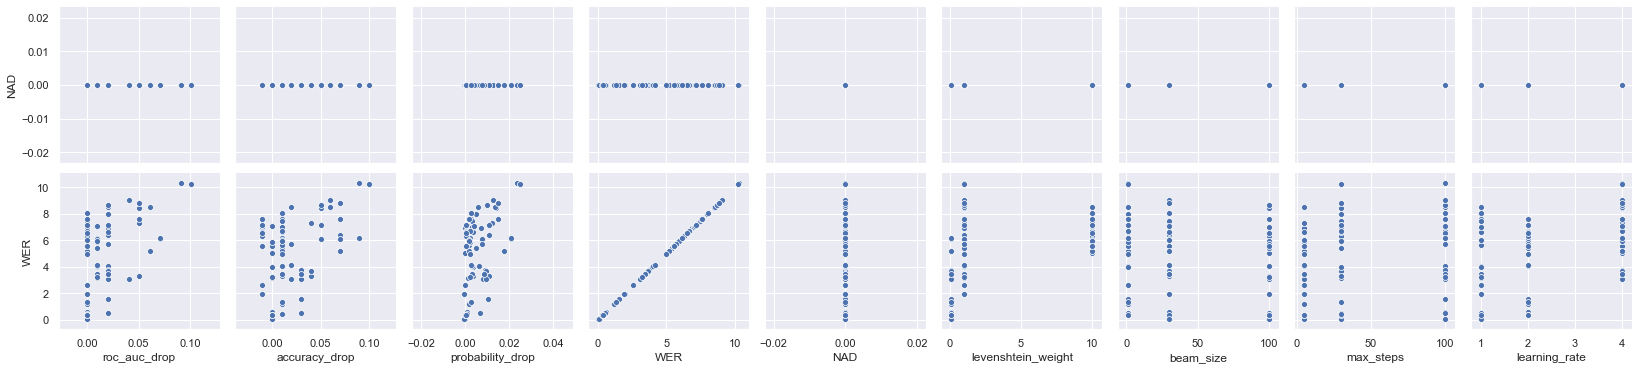

In [28]:
g = sns.pairplot(result, x_vars=result.columns.values, y_vars=['NAD', 'WER'])
plt.savefig(os.path.join(base_dir, f'stats_{method}.png'), dpi=150, bbox_inches='tight')

In [29]:
result.sort_values(by='NAD', ascending=False)

,roc_auc_drop,accuracy_drop,probability_drop,WER,NAD,levenshtein_weight,beam_size,max_steps,learning_rate
0,0.000000e+00,0.00,-0.000193,0.06,0.0,0.1,100,5,1.0
61,0.000000e+00,0.01,0.003430,7.03,0.0,10.0,100,30,1.0
59,1.110223e-16,-0.01,0.000435,6.60,0.0,10.0,30,30,2.0
58,0.000000e+00,0.00,-0.000193,0.06,0.0,0.1,30,5,1.0
57,0.000000e+00,0.01,0.002830,8.08,0.0,10.0,30,100,1.0
...,...,...,...,...,...,...,...,...,...
26,0.000000e+00,-0.01,-0.000409,1.91,0.0,1.0,100,5,1.0
25,1.010101e-02,0.00,0.001540,3.14,0.0,1.0,100,30,1.0
24,9.090909e-02,0.09,0.023630,10.33,0.0,1.0,1,100,4.0
23,0.000000e+00,-0.01,0.001648,7.58,0.0,10.0,1,100,4.0
